### Plot Gravitino results using the DataFrame stored in GravitinoResults.pcl 

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.5)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('GravitinoResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.

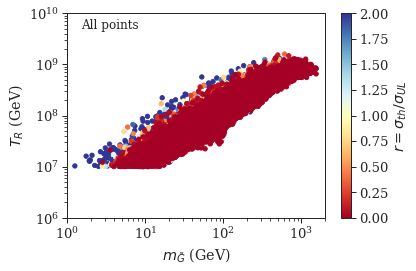

In [4]:
plt.figure()
mG = dataDF['mG']
TR = dataDF['TR']
r = dataDF['ExptRes.result0.r']
x,y,z = mG,TR,r
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=20, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e6,1e10)
plt.xlim(1e0,2e3)
plt.tight_layout()
plt.text(1.5,5e9, 'All points', fontsize=12)
plt.savefig('Gravitino_all_r.png',dpi=500)
plt.show()

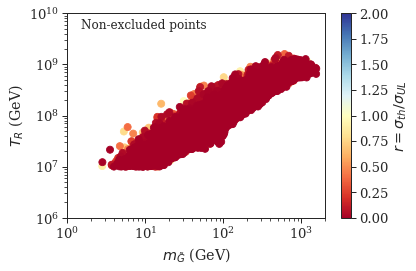

In [5]:
plt.figure()
allowedDF = dataDF[dataDF['ExptRes.result0.r'] < 1.]
mG = allowedDF['mG']
TR = allowedDF['TR']
r = allowedDF['ExptRes.result0.r']
x,y,z = mG,TR,r
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=50, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e6,1e10)
plt.xlim(1e0,2e3)
plt.text(1.5,5e9, 'Non-excluded points', fontsize=12)
plt.tight_layout()
plt.savefig('Gravitino_allowed_r.png',dpi=500)
plt.show()

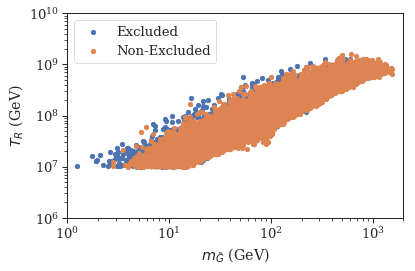

In [6]:
plt.figure()
allowedDF = dataDF[dataDF['excluded'] == False]
excludedDF = dataDF[dataDF['excluded'] == True]
mG = excludedDF['mG']
TR = excludedDF['TR']
x,y = mG,TR
cp = plt.scatter(x,y, s=20, label='Excluded')
mG = allowedDF['mG']
TR = allowedDF['TR']
x,y = mG,TR
cp = plt.scatter(x,y,s=20, label='Non-Excluded')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
plt.ylim(1e6,1e10)
plt.xlim(1e0,2e3)
plt.legend()
plt.tight_layout()
plt.savefig('Gravitino_all.png',dpi=500)
plt.show()

In [7]:
def getShortTxname(txList):
    if not isinstance(txList,list):
        return 'None'
    if len(txList) < 1:
        return 'None'
    elif len(txList) == 1:        
        return txList[0]
    else:
        if 'HSCP' in txList[0]:        
            return 'MultiHSCP'
        else:
            return 'MultiMET'
#Add short Txname notation:
dataDF['txshort'] = dataDF['ExptRes.result0.TxNames'].map(getShortTxname)

In [38]:
#Create dictionary with txname dataframes
groupedDF = OrderedDict([[tx,dataDF[(dataDF['txshort'] == tx) & (dataDF['ExptRes.result0.r'] > 1.)]] 
                         for tx in sorted(dataDF['txshort'].unique())])

In [41]:
#Define topology dictionary
txDict = {'MultiHSCP' : 'Multiple HSCP Topologies', 
          'THSCPM1b' : r'$p p \to X_{HSCP} + X_{HSCP}$',
         'THSCPM3' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM$',
         'THSCPM5' : r'$p p \to Z + Z,\; Z \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM7' : r'$p p \to Z_1 + Z_2,\; Z_1 \to X_{HSCP} + SM,\; Z_2 \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM8' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM + SM$',
         'TRHadGM1' : r'$p p \to G_{\mathrm{R-hadron}} + G_{\mathrm{R-hadron}}$',
         'TRHadQM1' : r'$p p \to Q_{\mathrm{R-hadron}} + Q_{\mathrm{R-hadron}}$',
         'Allowed' : 'Non-Excluded'
         }
#Check for undefined topologies:
for tx in groupedDF:
    if not tx in txDict:
        print(tx,'missing')

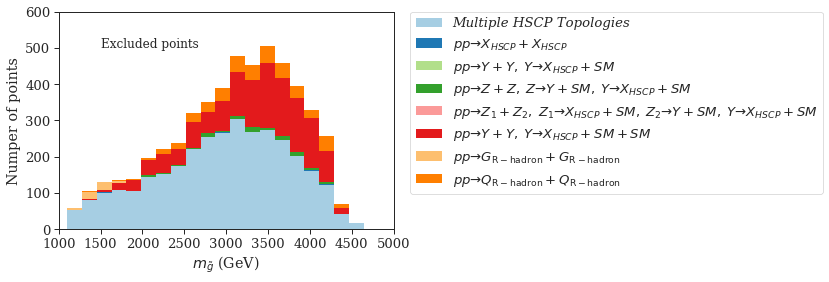

In [42]:
plt.figure()
xvals = [gDF['mass.1000021'] for gDF in groupedDF.values()]
nbins = 20
colors = sns.color_palette("Paired")[:len(xvals)]
# colors[-1] = (0.8,0.8,0.8)
n, bins, patches = plt.hist(xvals,nbins,stacked=True, 
                            histtype='bar', label=[txDict[tx] for tx in groupedDF],
                            linewidth=0, color=colors)
lgd = plt.legend(fontsize=10,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic'})
plt.xlim(1000.,5000.)
plt.ylim(0.,600.)
# plt.tight_layout()
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.ylabel('Numper of points')
plt.text(1500,500, 'Excluded points', fontsize=12)
plt.savefig('Gravitino_txnames.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

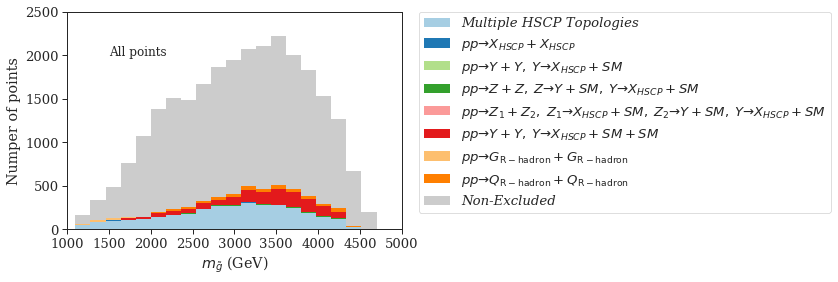

In [47]:
plt.figure()
groupedDF.update({'Allowed' : dataDF[dataDF['ExptRes.result0.r'] <= 1.]})
xvals = [gDF['mass.1000021'] for gDF in groupedDF.values()]
nbins = 20
colors = sns.color_palette("Paired")[:len(xvals)]
colors[-1] = (0.8,0.8,0.8)
n, bins, patches = plt.hist(xvals,nbins,stacked=True, 
                            histtype='bar', label=[txDict[tx] for tx in groupedDF],
                            linewidth=0, color=colors)
lgd = plt.legend(fontsize=10,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic'})
plt.xlim(1000.,5000.)
plt.ylim(0.,2500.)
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.ylabel('Numper of points')
plt.text(1500,2000, 'All points', fontsize=12)
plt.savefig('Gravitino_txnames_all.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()